# Decompose SST gradients into large-scale and mesoscale.

In order to decompose the SST gradients, we first filtered the SST field into large-scale and mesoscale features. Then the gradients are computed. The following code shows how to reproduce it for the year 1993, but it can be extended to the full record by uncommenting cells. 

In [1]:
# Import libraries
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs

import pylab as plt
import numpy as np
# Inline plotting
%matplotlib inline

In [2]:
from dask.distributed import Client

In [3]:
from utils import area,ccrs_land,add_patches
import datetime as datetime

In [4]:
c = Client()
c

Client Scheduler: tcp://127.0.0.1:40523 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 36 Memory: 154.62 GB


In [5]:
from astropy import convolution

In [6]:
dataset_SST = xr.open_dataset('../datasets/SST_timeseries.nc',chunks={'lat':10,'lon':10})

In [7]:
dataset_SST

,Array,Chunk
Bytes,2.75 GB,4.24 MB
Shape,"(10593, 180, 360)","(10593, 10, 10)"
Count,649 Tasks,648 Chunks
Type,float32,numpy.ndarray


# Large scale SST

In [8]:
SST_data = dataset_SST.SST.sel(time=slice('1992','2020'))
large_scale_sst = SST_data.copy()

In [9]:
kernel=np.ones((1,13,13)) # 0.25*13 = 3.25, the kernel size must be an odd number.

large_scale_sst.data = convolution.convolve(SST_data,boundary='wrap', kernel = kernel, preserve_nan=True)

In [10]:
mesoscale_sst = SST_data - large_scale_sst

In [11]:
mesoscale_sst

,Array,Chunk
Bytes,2.75 GB,4.24 MB
Shape,"(10593, 180, 360)","(10593, 10, 10)"
Count,3242 Tasks,648 Chunks
Type,float32,numpy.ndarray


## Compute gradients

#### Large-scale

In [12]:
dy,dx = area(large_scale_sst.lat,large_scale_sst.lon,return_grid=True)

In [13]:
large_scale_sst_dx = large_scale_sst.differentiate('lon')/dx
large_scale_sst_dy = large_scale_sst.differentiate('lat')/dy[np.newaxis,:,np.newaxis]

#### Mesoscale

In [14]:
dy,dx = area(mesoscale_sst.lat,mesoscale_sst.lon,return_grid=True)

In [15]:
mesoscale_sst_dx = mesoscale_sst.differentiate('lon')/dx
mesoscale_sst_dy = mesoscale_sst.differentiate('lat')/dy[np.newaxis,:,np.newaxis]

## Compute magnitudes

In [16]:
large_scale_sst_magnitude = np.sqrt( large_scale_sst_dx**2 + large_scale_sst_dy**2 ).compute()

In [17]:
mesoscale_sst_magnitude = np.sqrt( mesoscale_sst_dx**2 + mesoscale_sst_dy**2 ).compute()

In [18]:
T_grad_large_scale = large_scale_sst_magnitude.rolling(time=365,center=True).mean()

In [19]:
T_grad_small_scale = mesoscale_sst_magnitude.rolling(time=365,center=True).mean()

In [20]:
T_grad_large_scale = T_grad_large_scale.to_dataset(name='SST_grad_large_scale')

In [21]:
T_grad_small_scale = T_grad_small_scale.to_dataset(name='SST_grad_small_scale')

In [22]:
dataset = xr.merge([T_grad_small_scale,T_grad_large_scale])

In [23]:
dataset.attrs['title'] = "SST gradients scale decomposition (Large scale & mesoscale)."
dataset.attrs['Description'] = """SST gradients computed from OISST-NOAA"""
dataset.attrs['Publication'] = "Dataset created for Martínez-Moreno, J. et. al. 2020: \n 'Global changes in oceanic mesoscale currents over the satellite altimetry record'"
dataset.attrs['Author'] = "Josué Martínez-Moreno"
dataset.attrs['Contact'] = "josue.martinezmoreno@anu.edu.au"

dataset.attrs['Created date'] = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")

units = [r"$^\circ C m^{-1}$",r"$^\circ C m^{-1}$"]
names = ["SST_grad_small_scale","SST_grad_large_scale"]
long_names = ["Mesoscale Sea Surface Temperature gradient magnitude"," Large-scale Sea Surface Temperature gradient magnitude"]

counter=0
for mask_name in list(dataset.data_vars):
    dataset[mask_name].attrs['units'] = units[counter]
    dataset[mask_name].attrs['name'] = names[counter]
    dataset[mask_name].attrs['long_name'] = long_names[counter]
    
    dataset[mask_name].attrs['missing_value'] = np.nan
    dataset[mask_name].attrs['valid_min'] = np.nanmin(dataset[mask_name])
    dataset[mask_name].attrs['valid_max'] = np.nanmax(dataset[mask_name])
    dataset[mask_name].attrs['valid_range'] = [np.nanmin(dataset[mask_name]),np.nanmax(dataset[mask_name])]
    
    counter+=1

In [24]:
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in dataset.data_vars}

dataset.to_netcdf('../datasets/SST_grads_decomposition_timeseries.nc', encoding=encoding)

In [25]:
mean_large_scale_sst_magnitude = T_grad_large_scale.SST_grad_large_scale.mean('time')
mean_mesoscale_sst_magnitude = T_grad_small_scale.SST_grad_small_scale.mean('time')

### Plot mean large-scale and mesoscale SST gradient magnitude.

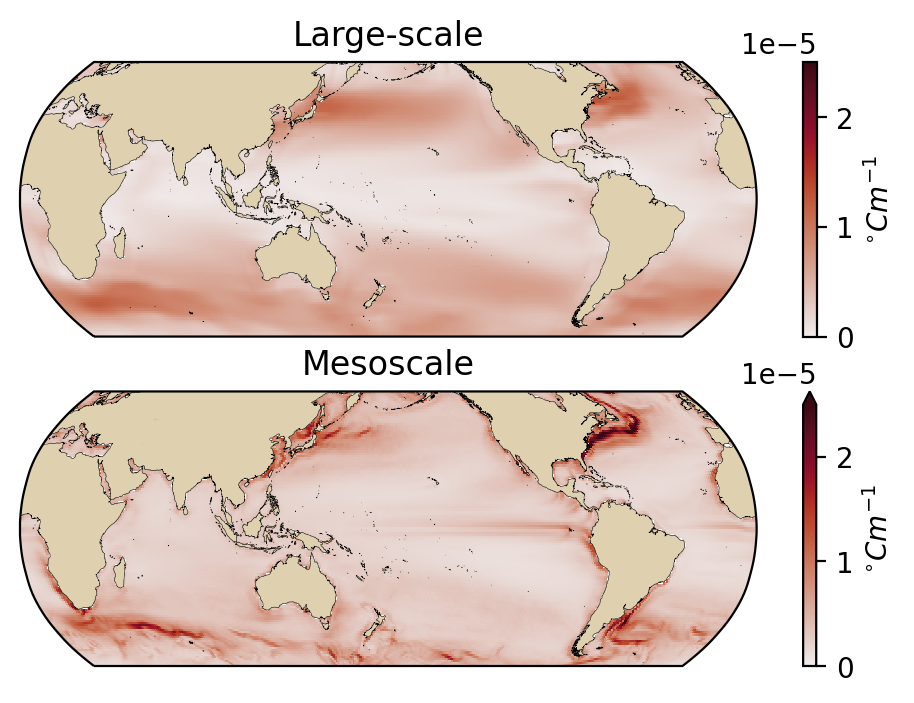

In [26]:
fig = plt.figure(figsize=(6,4), dpi=200)
ax = fig.add_subplot(2, 1, 1, projection = ccrs.Robinson(central_longitude=180))

im = mean_large_scale_sst_magnitude.plot(transform=ccrs.PlateCarree(),cbar_kwargs=dict(label="$^{\circ}C m^{-1}$"),
              cmap=cm.cm.amp, vmin=0, vmax=2.5e-5,ax=ax)
ax.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax.add_feature(ccrs_land)
ax.set_title('Large-scale')
add_patches(ax)

ax = fig.add_subplot(2, 1, 2, projection = ccrs.Robinson(central_longitude=180))

im = mean_mesoscale_sst_magnitude.plot(transform=ccrs.PlateCarree(),cbar_kwargs=dict(label="$^{\circ}C m^{-1}$"),
              cmap=cm.cm.amp, vmin=0, vmax=2.5e-5,ax=ax)
ax.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax.add_feature(ccrs_land)
ax.set_title('Mesoscale')
add_patches(ax)